In [26]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, Input
from tensorflow.keras import Model

In [27]:
# Load CSV files
train_df = pd.read_csv("C:/Users/anany/Desktop/leaf/data/train.csv")  # This contains 'filename' and 'label' columns
test_df = pd.read_csv("C:/Users/anany/Desktop/leaf/data/test.csv")    # This contains 'filename' and 'image path' columns


In [28]:
def load_images_from_df(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = row['filename']
        image = load_img(img_path, target_size=(128, 128)) 
        image = img_to_array(image)
        images.append(image)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

# Load training images and labels
X_train, y_train = load_images_from_df(train_df)

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


In [29]:
def create_unique_model(input_shape=(128, 128, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # First block
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x1 = MaxPooling2D(pool_size=(2, 2))(x)

    # Second block
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x1)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x2 = MaxPooling2D(pool_size=(2, 2))(x)

    # Third block
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x2)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x3 = MaxPooling2D(pool_size=(2, 2))(x)

    # Skip connection (Residual Block)
    x = Conv2D(128, (1, 1), padding='same')(x3)
    x = Add()([x, x3])
    x = tf.keras.activations.relu(x)

    # Flatten and Dense layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Create and compile the model
model = create_unique_model(num_classes=len(label_encoder.classes_))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │             896 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 128, 128, 32)      │             128 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128, 128, 32)      │             128 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 64, 64, 32)        │               0 │ batch_normalization_1[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 64, 64, 64)        │             256 │ conv2d_5[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64, 64, 64)        │             256 │ conv2d_6[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 32, 32, 64)        │               0 │ batch_normalization_3[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 32, 32, 128)       │             512 │ conv2d_7[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 32, 32, 128)       │         147,58

 Total params: 8,694,947 (33.17 MB)

 Trainable params: 8,694,051 (33.17 MB)

 Non-trainable params: 896 (3.50 KB)

In [36]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

model.fit(datagen.flow(X_train, y_train_encoded, batch_size=32), epochs=2, steps_per_epoch=len(X_train) // 32)


Epoch 1/2


C:\Users\anany\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.3900 - loss: 1.1199
Epoch 2/2
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4062 - loss: 0.9974


C:\Users\anany\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted label: healthy


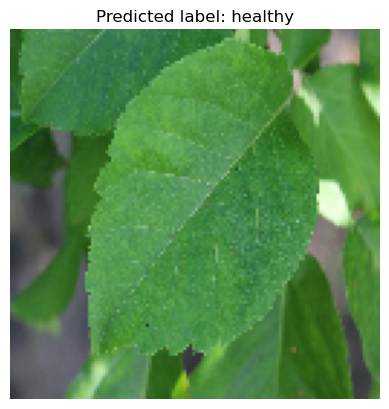

In [37]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Choose an image from the test set
img_to_predict = test_df.iloc[300]  # Change index as needed
img_path = img_to_predict['filename']  # Ensure you use the correct column name

# Check if the image exists
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image path does not exist: {img_path}")

# Load and preprocess the image
img = load_img(img_path, target_size=(128, 128))  # Ensure size matches model input
img_array = img_to_array(img) / 255.0  # Normalize the image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
try:
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Output the predicted class
    predicted_label = label_encoder.inverse_transform([predicted_class])
    
    # Print the predicted label
    print(f'Predicted label: {predicted_label[0]}')

    # Display the image
    plt.imshow(img)  # Use the original image
    plt.title(f'Predicted label: {predicted_label[0]}')
    plt.axis('off')  # Hide axis
    plt.show()

except Exception as e:
    print(f"Error during prediction: {e}")
